In [2]:
# Julia version code
"""
nonnegative linear regression 
"""
# Discussion from Dec 22
# 1. Currently, our runtime is O(n/sqrt(eps)*(m+n)). The per iteration O(m)
# is unavoidable; however, IF we are NOT required to output the optimizer xtilde_ktotal, 
# then by maintaining 1^T x in each iteration (at a cost of O(1)), we can completely
# avoid O(n) per iteration. 

using LinearAlgebra, BenchmarkTools, Plots, Convex, SCS, NonNegLeastSquares, MLDatasets



In [80]:
function alg_ours(C::Matrix{Float64}, b::Matrix{Float64}, ϵ::Float64, M:: Int64)
    
    extra_term_nnls = 0.5*norm(b)^2
    m, n = size(C)
    K = ceil(n / √ϵ)
    previous_A = 1.0/n
    previous_a = previous_A
    a = 1.0/(n*n)
    A = (n+1.0) /(n * n)
    col_norm = norm.(eachcol(C))
    inv_col_norm_square = 1.0 ./(col_norm.^2)
    idx_seq = 1:n
    t = x = zeros(n)
    p = zeros(n)
    j = rand(idx_seq)
    p[j] += inv_col_norm_square[j]
    x[j] = p[j]
    # x̃ = deepcopy(x)
    previous_y = zeros(m)
    y = x[j] * C[:, j]
    # record Ax
    z = x[j] * C[:, j]
    ȳ = (n+1) * y
    s = zeros(n)
    #func_value = 0
    func_value=zeros(Int(ceil(K/M)))
    i=0
    while M*i < K # Stopping Criterion
        t[:]=x[:] # inner loop
        for k = 2:M
            j = rand(idx_seq)
            p[j] += - n * inv_col_norm_square[j] * a * (sum(C[:,j] .* ȳ) - 1) # Will pass ȳ to the code
            prev_tj = t[j]
            t[j] = min(inv_col_norm_square[j], max(0, x[j]+p[j]))
            # record At
            z[:] += C[:, j] * (t[j] - prev_tj)
            previous_y[:] = y[:]
            y[:] = previous_A/A * y[:] + a/A * z[:] + (n-1) * a/A * (t[j] - prev_tj) * C[:,j]
            s[j] += ((n-1) * a -  previous_A) * (t[j] - prev_tj)
            previous_a, previous_A = a, A
            a = min(n * a/(n-1), sqrt(A)/(2*n))
            ȳ[:] = y[:] + previous_a/a * (y[:] - previous_y[:])
            A += a
        end
        x[:] = t[:]
        x̃ = x + 1.0/previous_A * s
        C_x̃ = C * x̃
        i=i+1
        func_value[i] = 0.5 * sum(C_x̃ .* C_x̃) - sum(x̃)+extra_term_nnls
        #@info "pass: $i, func_value: $func_value"
        
        # Redefine the parameters
        #s = zeros(n)
        p = zeros(n)
        previous_y = zeros(m)
        
    end
    return(func_value)
end

alg_ours (generic function with 2 methods)

In [63]:
# https://github.com/ahwillia/NonNegLeastSquares.jl
function alg_fast_lawsonhanson(A, b)
    xfnnls = nonneg_lsq(A,b;alg=:fnnls) # Fast NNLS

    fnnls_optval = 0.5*norm(A*xfnnls - b)^2
    
    print("\n f-nnls (nnls package) value is ", fnnls_optval)
    
    return(fnnls_optval)
end

alg_fast_lawsonhanson (generic function with 1 method)

Test for simulation


 f-nnls (nnls package) value is 5.534522546943587f = Plot{Plots.GRBackend() n=1}


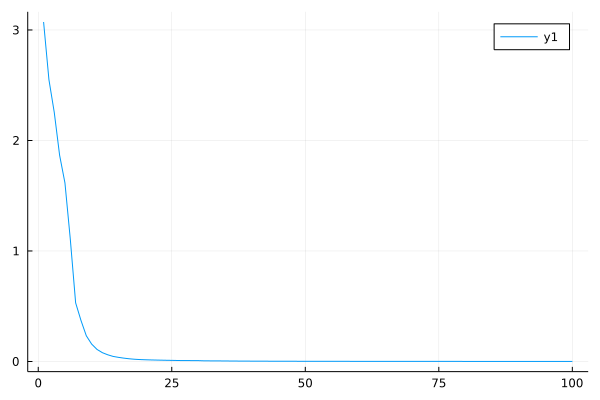

In [81]:
# Main code
function remove_col1(A,b)#Chenghui has an idea to optimize this for speed ("filter")
    s=A'*b # n*1 
    B=A[:,vec(s.>0)] # m*b matrix where b is smaller than n
    s=s[vec(s.>0)] # s is b*1 in dimensions
    return B./s'
end

epsilon = 0.0001 

############# 
n = 1000 # variable dimension 
m = 200 # Number of data points
b=rand(m,1)-repeat([0.3],m,1)
A_init =  max.(0, randn(m, n)) #rand(m,n)#
############

############ Mnist： uncomment 
#train_x, train_y = MNIST.traindata()
#A = Array{Int64}
#b = Array{Int64}
#A_init = reshape(train_x,60000,28*28)
#b = train_y
#test_x,  test_y  = MNIST.testdata()
############


 A = remove_col1(A_init,b)
############ Mnist: uncomment this
# A = Float64.(A)
# b = Float64.(b)
# b1 = vcat(b')
############

(m,n) = size(A) # Redefine the size number n and m to prevent triviality.


#@time begin
our_result = alg_ours(A, b, epsilon, n)
#our_result = alg_ours(A, b1, epsilon)
#end 


######## Plot
s = alg_fast_lawsonhanson(A, b) # optima value
f = plot(our_result.-s)
@show f   

# @time begin 
# s=alg_fast_lawsonhanson(A, b)
# end

# @time begin 
# alg_lawsonhanson(A, b)
# end

# @time begin 
# alg_pivot(A, b)
# end

In [49]:
func_value

100-element Array{Float64,1}:
 8.82948638499188
 8.303192865677165
 7.9507645521764365
 7.64834008080215
 7.287266113912496
 7.183144635310543
 7.03270080145585
 6.845798507719006
 6.400858025510396
 6.548066987647505
 6.657051947357191
 6.3397402685584305
 7.198169693327616
 ⋮
 7.090303689126772
 6.975124681710398
 7.414154714349184
 8.619480024801355
 7.349713563721357
 7.660680105562286
 8.520909847885097
 7.934381573514543
 7.386834084673022
 7.460075274296512
 7.228695094425858
 7.277048768140931